In [1]:
from astropy.table import Table
from astropy.io import fits
import pandas as pd
import time as t
import numpy as np
import os

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
rc("animation", html = "jshtml")
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.lines import Line2D
# plt.style.use('default')

from pathlib import Path

### zcat

In [2]:
base = '/global/cfs/cdirs/desi/public/dr1/spectro/redux/iron/zcatalog/v1'

In [3]:
ini = t.time()
cat = Table.read(f'{base}/zall-pix-iron.fits')
end = t.time()
len(cat)

28425963

In [5]:
cat[:5]

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY,DESINAME
,,,,,,,,,,,,,,,,deg,deg,mas / yr,mas / yr,yr,,,,,,,,,,,mag,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,,,arcsec,,,,,mag,mag,mag,mas,,,,,,,,,,,,,,,,,,,,,deg,deg,,s,,,mm,mm,mm,mm,,deg,arcsec,deg,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bool,int16,bool,int16,bool,bytes22
39628473198710603,cmx,other,2152,2152,0.8042057637744875,9.589004434794145e-06,0,10003.721982955933,117.8692939130018 .. 5.6065445634658255,7928,GALAXY,--,10,6319.3509159088135,0,23.764862479118218,29.832378962505196,0.0,0.0,2020.9597,3072,1,TGT,0.20970260241473437,3,9010,0237p297,494512,3915,EXP,0.05433502,1.3540096,2.9762945,10.3957405,27.52511,48.7791,531.4606,123.64128,19.293917,2.6645064,0.6410277,0.4344953,0.95507884,3.3359442,0.43980038,0.9776775,3.4928923,0,1.0,1.1636901,0.18920432,-0.24198028,0,--,0.0,0.0,0.0,0.0,S,3200,1,3072,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.764862479118218,29.832378962505196,4,3600.0,1,1,-0.00675,0.0091515025,-0.0055,0.014124447,0.71950334,23.76489350625343,0.08943564,29.832358617984326,0.1715876,59200.06640136,59200.12381137,59200.095110124996,388.2487,0.28193328,75.31641,283.94504,1451.2411,530.06067,7.442073,2.1379867,34921.81,78.42465,6280.0347,0.1178768,7149.4326,36527.004,22.981281,113.36229,5.09169e-05,260.3999,9.6547765e-06,0.0,11533.531,6.420885e-05,52.333626,120.35188,35310.06

In [4]:
(end-ini)/60

1.979544468720754

In [7]:
for c in cat.columns:
    print(c)

TARGETID
SURVEY
PROGRAM
HEALPIX
SPGRPVAL
Z
ZERR
ZWARN
CHI2
COEFF
NPIXELS
SPECTYPE
SUBTYPE
NCOEFF
DELTACHI2
COADD_FIBERSTATUS
TARGET_RA
TARGET_DEC
PMRA
PMDEC
REF_EPOCH
FA_TARGET
FA_TYPE
OBJTYPE
SUBPRIORITY
OBSCONDITIONS
RELEASE
BRICKNAME
BRICKID
BRICK_OBJID
MORPHTYPE
EBV
FLUX_G
FLUX_R
FLUX_Z
FLUX_W1
FLUX_W2
FLUX_IVAR_G
FLUX_IVAR_R
FLUX_IVAR_Z
FLUX_IVAR_W1
FLUX_IVAR_W2
FIBERFLUX_G
FIBERFLUX_R
FIBERFLUX_Z
FIBERTOTFLUX_G
FIBERTOTFLUX_R
FIBERTOTFLUX_Z
MASKBITS
SERSIC
SHAPE_R
SHAPE_E1
SHAPE_E2
REF_ID
REF_CAT
GAIA_PHOT_G_MEAN_MAG
GAIA_PHOT_BP_MEAN_MAG
GAIA_PHOT_RP_MEAN_MAG
PARALLAX
PHOTSYS
PRIORITY_INIT
NUMOBS_INIT
CMX_TARGET
DESI_TARGET
BGS_TARGET
MWS_TARGET
SCND_TARGET
SV1_DESI_TARGET
SV1_BGS_TARGET
SV1_MWS_TARGET
SV1_SCND_TARGET
SV2_DESI_TARGET
SV2_BGS_TARGET
SV2_MWS_TARGET
SV2_SCND_TARGET
SV3_DESI_TARGET
SV3_BGS_TARGET
SV3_MWS_TARGET
SV3_SCND_TARGET
PLATE_RA
PLATE_DEC
COADD_NUMEXP
COADD_EXPTIME
COADD_NUMNIGHT
COADD_NUMTILE
MEAN_DELTA_X
RMS_DELTA_X
MEAN_DELTA_Y
RMS_DELTA_Y
MEAN_PSF_TO_FIBE

In [10]:
np.unique(cat['OBJTYPE'])

""
BAD
NON
SKY
TGT


In [13]:
cols = ['name','ra','dec','z_lens','z_source','zl_phot','zs_phot','Rein','lens_mag_i','source_mag_i','type','discovery','grade','Reference']
hsc = pd.read_csv('/pscratch/sd/v/vtorresg/desi-lenses/hsc_full_catalog.csv', header=None, names=cols)

In [18]:
row_h = hsc.iloc[0]

In [19]:
row_z = cat[0]

Necesito hacer crossmatching de los dos catalogos

- hsc tiene ra,dec
- en el paper definen un radio de 6''
- puedo tomar las coordenadas de cada lente para tomarlas como centro de un circulo de radio 6''
- luego puedo filtrar el catalogo de z

------------
- puedo calcular la distancia entre el lente y los objetos de desi
- calcular la distancia ra1,dec1 ra2,dec2 y ver si tienen una separacion angular de <= 6''

In [21]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [24]:
p_h = SkyCoord(ra=row_h['ra']*u.deg, dec=row_h['dec']*u.deg)
p_r = SkyCoord(ra=row_z['TARGET_RA']*u.deg, dec=row_z['TARGET_DEC']*u.deg)

$$\ cos \theta = \sin \delta_1 \sin \delta_2 + \cos \delta_1 \cos \delta_2 \cos \left( \alpha_1 - \alpha_2 \right)$$

In [25]:
d = p_h.separation(p_r)
d

<Angle 35.44450169 deg>

skycoord tiene un metodo search_around_sky

In [30]:
#la tabla ya esta en grados?
d_coord = SkyCoord(ra=cat['TARGET_RA'], dec=cat['TARGET_DEC'])

In [35]:
h_coord = SkyCoord(ra=hsc['ra'].to_numpy()*u.deg, dec=hsc['dec'].to_numpy()*u.deg)

In [37]:
d_coord.shape

(28425963,)

In [41]:
row = h_coord[0]
row

<SkyCoord (ICRS): (ra, dec) in deg
    (0.03524, 2.44944)>

In [42]:
idx_d, idx_h, sep2d, _ = d_coord.search_around_sky(h_coord, seplimit=6*u.arcsec)

In [43]:
idx_d #index de los objetos de desi

array([   2,    3,    5, ..., 3955, 3956, 3956])

In [44]:
idx_h #index de objetos de hsc

array([17079632, 17079353, 18560974, ..., 18061521,  7765506, 18566001])

In [45]:
sep2d #sep entre los pares

<Angle [1.06917721e-05, 1.40911073e-05, 1.69098141e-05, ...,
        4.97801121e-06, 2.04684749e-07, 2.04684749e-07] deg>

In [46]:
_ #esta seria la dis

<Quantity [1.86606627e-07, 2.45936218e-07, 2.95131932e-07, ...,
           8.68826857e-08, 3.57242280e-09, 3.57242280e-09]>

### cross

In [66]:
f = [str(x) for x in Path('/pscratch/sd/v/vtorresg/umap_analysis/data/text_files/').iterdir()]
for file in f:
    if '_132' in file:
        print(file)

/pscratch/sd/v/vtorresg/umap_analysis/data/text_files/20210414_132.txt
/pscratch/sd/v/vtorresg/umap_analysis/data/text_files/20240115_1329.txt
/pscratch/sd/v/vtorresg/umap_analysis/data/text_files/20240115_1328.txt
/pscratch/sd/v/vtorresg/umap_analysis/data/text_files/20240115_1327.txt


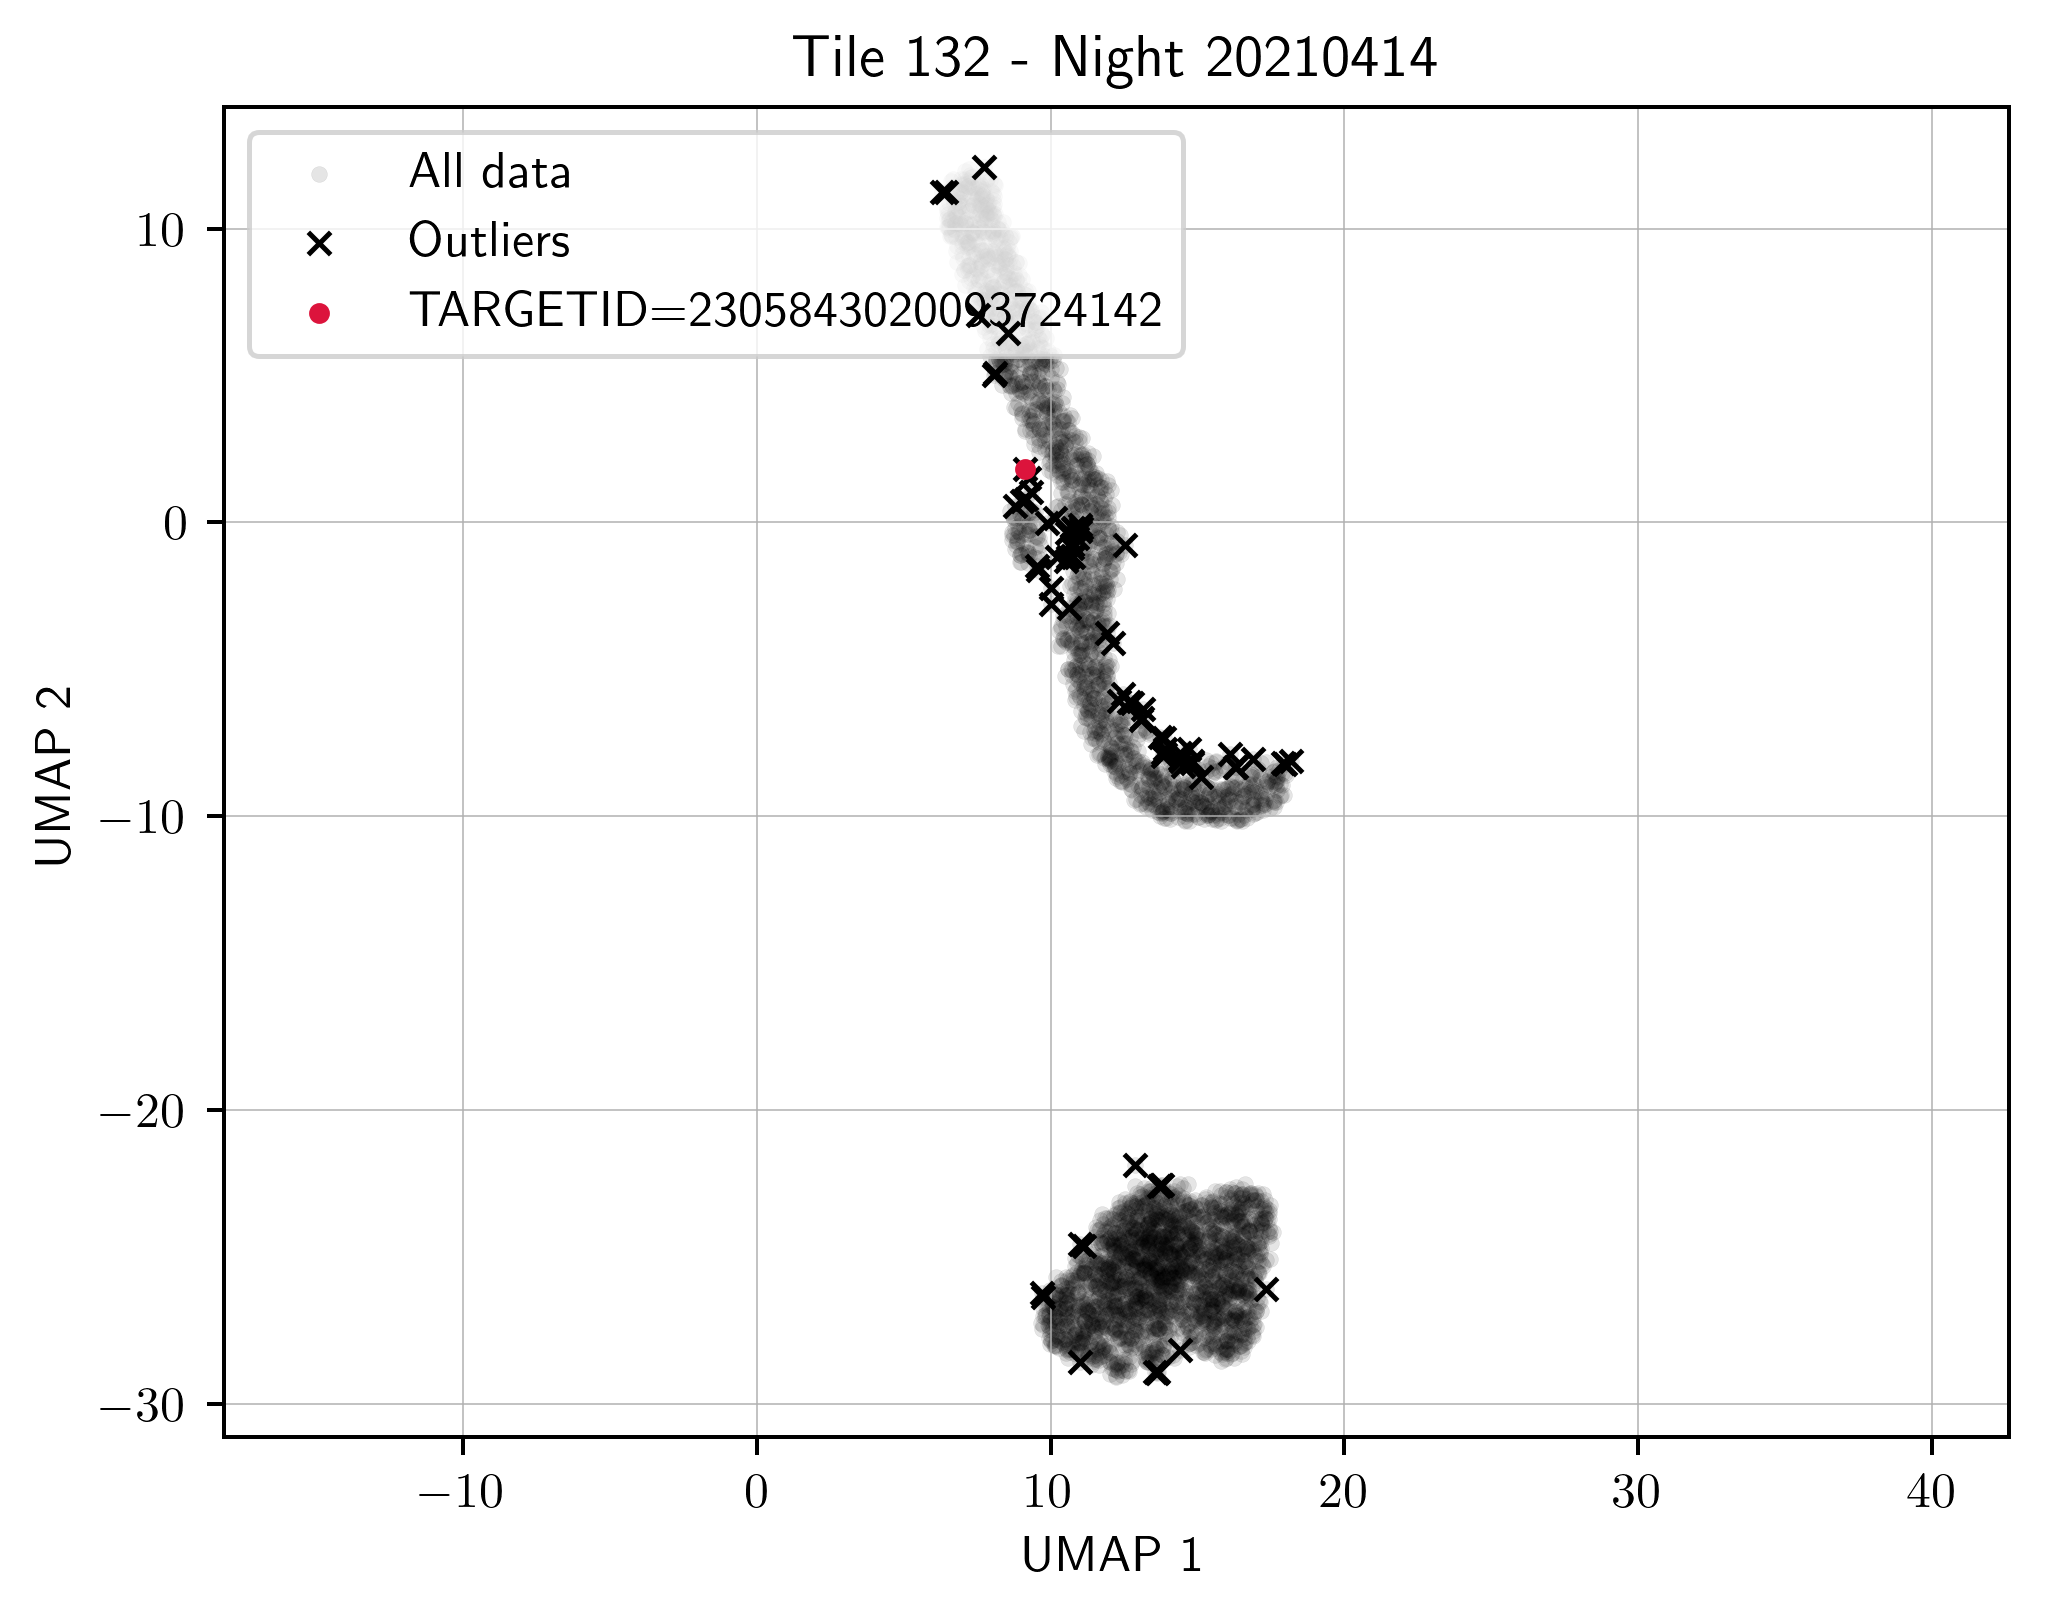

In [67]:
tile = 132
night = 20210414
target_id = 2305843020093724142 


data = np.load(f"/pscratch/sd/v/vtorresg/umap_analysis/data/processed/umap/umap_{night}_{tile}.npz", allow_pickle=True)

arr = data["embedding"]
mask = data["outlier_mask"]
ids  = data["ids"]

target_mask = (ids == target_id)

fig, ax = plt.subplots()
plt.grid(linewidth=0.3, zorder=-1)

ax.scatter(arr[:, 0], arr[:, 1], s=10, zorder=1, color='black', linewidths=0.1,
           edgecolor='black', label='All data', alpha=0.1)

outliers = arr[mask]
ax.scatter(outliers[:, 0], outliers[:, 1], zorder=10, color='black', s=20,
           label='Outliers', marker='x', linewidths=1)

target_coords = arr[target_mask]
ax.scatter(target_coords[:, 0], target_coords[:, 1], 
               zorder=20, color='crimson', s=10, marker='o',
               label=f'TARGETID={target_id}')

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.legend(loc="upper left")
plt.title(f"Tile {tile} - Night {night}")
ax.set_aspect("equal", adjustable="datalim")
plt.show()

In [ ]:
kids = pd.read_csv('/pscratch/sd/v/vtorresg/desi-lenses/kids_desi_matches.csv')
lens = pd.read_csv('/pscratch/sd/v/vtorresg/desi-lenses/lenscat_desi_matches.csv')
hsc = pd.read_csv('/pscratch/sd/v/vtorresg/desi-lenses/hsc_desi_matches.csv')
out = pd.read_csv('/pscratch/sd/v/vtorresg/desi-lenses/df_outliers.csv')

In [ ]:
kids_u = kids.drop_duplicates(subset=["TARGETID"])
hsc_u  = hsc.drop_duplicates(subset=["TARGETID"])
lens_u = lens.drop_duplicates(subset=["TARGETID"])
out_u  = out.drop_duplicates(subset=["TARGETID"])

In [ ]:
S_out  = set(out_u["TARGETID"])
S_kids = set(kids_u["TARGETID"])
S_hsc  = set(hsc_u["TARGETID"])
S_lens = set(lens_u["TARGETID"])

kids_in_out = S_kids & S_out
hsc_in_out  = S_hsc  & S_out
lens_in_out = S_lens & S_out

print("kids ∩ out:", len(kids_in_out))
print("hsc  ∩ out:", len(hsc_in_out))
print("lens ∩ out:", len(lens_in_out))

kids_rows_in_out = kids_u[kids_u["TARGETID"].isin(kids_in_out)]
hsc_rows_in_out  = hsc_u[hsc_u["TARGETID"].isin(hsc_in_out)]
lens_rows_in_out = lens_u[lens_u["TARGETID"].isin(lens_in_out)]

In [ ]:
kids_hsc  = S_kids & S_hsc
kids_lens = S_kids & S_lens
hsc_lens  = S_hsc  & S_lens
all_three = S_kids & S_hsc & S_lens

print("kids ∩ hsc:", len(kids_hsc))
print("kids ∩ lens:", len(kids_lens))
print("hsc ∩ lens:", len(hsc_lens))
print("kids ∩ hsc ∩ lens:", len(all_three))

In [ ]:
def tag(df, name):
    return df[["TARGETID"]].drop_duplicates().assign(**{name: True})

summary = (pd.Series(sorted(S_kids | S_hsc | S_lens | S_out), name="TARGETID").to_frame()
           .merge(tag(kids_u,"in_kids"), on="TARGETID", how="left")
           .merge(tag(hsc_u, "in_hsc"),  on="TARGETID", how="left")
           .merge(tag(lens_u,"in_lens"), on="TARGETID", how="left")
           .merge(tag(out_u, "in_out"),  on="TARGETID", how="left")
           .fillna(False))

In [ ]:
combo_counts = (summary
                .assign(combo=list(zip(summary.in_kids, summary.in_hsc,
                                       summary.in_lens, summary.in_out)))
                .value_counts("combo")
                .sort_values(ascending=False))

combo_counts.head()

In [49]:
unique_ids = (pd.concat([kids["TARGETID"], hsc["TARGETID"], lens["TARGETID"]])
                .dropna()
                .drop_duplicates()
                .to_numpy())

print(len(unique_ids), "IDs únicos")

8288 IDs únicos


In [ ]:
unique_ids_series = pd.Series(unique_ids, name="TARGETID")
unique_ids_df = unique_ids_series.to_frame()

In [50]:
n_in_df = out["TARGETID"].isin(unique_ids).sum()
print(f"{n_in_df} de {len(unique_ids)}")

197 de 8288 IDs únicos están en df


In [45]:
df_in = out[out["TARGETID"].isin(unique_ids)]

In [46]:
df_in

,TARGETID,TILEID,FIBER
11650,39627736309827065,25242,2189
17265,39627927314236371,21699,1470
20177,39633247927274756,22184,1363
26141,39627727887665550,24807,3733
41780,39633094784844881,20365,1573
...,...,...,...
1120492,39627736972526855,20663,1250
1132515,39627853871975326,1484,3993
1134260,2349942446227457,2286,1055
1135896,39627790537985288,23687,1041


In [61]:
lens[lens['TARGETID']==2305843020093724142]

,TARGETID,HEALPIX,SURVEY,Z,ZERR,ZWARN,SPECTYPE,SUBTYPE,TARGET_RA,TARGET_DEC,...,NAME,RA [DEG],DEC [DEG],ZLENS,TYPE,GRADING,REF,RA,DEC,SEPARATION_ARCSEC
8583,2305843020093724142,10378,sv3,0.016128,0.000003,0,GALAXY,NaN,194.355201,27.404597,...,403,194.35521,27.40457,0.0162778,galaxy,probable,Talbot et al. (2022) - arXiv:2206.09902,194.35521,27.40457,0.099978


In [62]:
out[out['TARGETID']==2305843020093724142]

,TARGETID,TILEID,FIBER
87057,2305843020093724142,133,973
211500,2305843020093724142,132,646


In [63]:
hsc[hsc['TARGETID']==2305843020093724142]

,TARGETID,HEALPIX,SURVEY,Z,ZERR,ZWARN,SPECTYPE,SUBTYPE,TARGET_RA,TARGET_DEC,...,ZL_PHOT,ZS_PHOT,REIN,LENS_MAG_I,SOURCE_MAG_I,TYPE,DISCOVERY,GRADE,REFERENCE,SEPARATION_ARCSEC


In [64]:
t = pd.read_csv('/pscratch/sd/v/vtorresg/desi-lenses/resultados2.csv')
t

,TARGETID,TILEID,FIBER,NIGHT,HEALPIX,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,...,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,NAME,RA,DEC,Z_LENS,Z_SOURCE,TYPE
0,39633136497199715,338,1163,20210414,9831,0.542448,0.000085,0,GALAXY,240.780500,...,1152921504606847233,257,0,0,160307+431421,240.780515,43.239353,-99.000,-99.0,GG
1,39627764264865286,257,4237,20210413,25933,0.537875,0.000130,0,GALAXY,220.386171,...,5764607523034234880,131074,0,17179869184,144132-005359,220.386700,-0.899900,-99.000,-99.0,CG
2,39627847618266716,15,1774,20210412,27333,0.530833,0.000101,0,GALAXY,148.575565,...,1152921504606912513,65537,0,0,095418+023433,148.575590,2.575949,-99.000,-99.0,GG
3,39633149734424060,363,3768,20210409,9986,0.381352,0.000077,0,GALAXY,247.821816,...,1152921504606847233,514,0,0,163117+440649,247.821823,44.113670,0.382,-99.0,GG
4,39627817436056624,16,838,20210417,27245,0.550145,0.000103,0,GALAXY,149.631163,...,5764607523034300417,131074,0,17179869184,095831+010937,149.631100,1.160300,-99.000,-99.0,CG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,39627751400935869,20273,3940,20220407,26958,0.612537,0.000137,0,GALAXY,173.723007,...,1152921504606912513,65545,0,0,HSCJ1134-0122,173.723005,-1.380451,-99.000,-99.0,GG
66,39627770313048831,21664,1994,20220430,25944,0.499042,0.000078,0,GALAXY,220.779902,...,1152921504606912513,65537,0,0,144307-004056,220.779854,-0.682249,-99.000,-99.0,GQ
67,39627866001901162,25192,4757,20220428,27063,0.472572,0.000107,0,GALAXY,164.555379,...,1152921504606846976,65537,0,0,105813+031136,164.555369,3.193392,-99.000,-99.0,GG
68,39633153568014967,25856,4741,20220513,10669,1.687553,0.000099,0,GALAXY,205.124163,...,5764607523034234880,1028,0,17179869184,134029+441003,205.124000,44.167700,-99.000,-99.0,CG
